# Import

## Modules

In [1]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm
import altair as alt
import dask.dataframe as dd
import sys
from pathlib import Path
from itertools import product

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

## Set this to true to see legacy charts
debug=False

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Setup paths

In [2]:
PROJECT_ROOT = Path.cwd().parent
PATH_DATA = PROJECT_ROOT / "data" / "csv"
sys.path.append(str(PROJECT_ROOT))

## Scripts

In [3]:
import data.collectors as dc

## Data

In [4]:
raw_data = dd.read_csv(str(PATH_DATA / "by_day" / '*.csv'), include_path_column=True)
raw_data = pd.read_csv(str(PATH_DATA / "covid19.csv"))

# Data Cleaning

## Parse dates as datetime objects

In [5]:
# int_data = raw_data.compute()
# int_data["Date"] = int_data["path"].apply(lambda x: Path(x).stem)
# int_data.drop(columns=["path"], inplace=True)
raw_data["date"] = pd.to_datetime(raw_data["date"])
raw_data.sort_values(by="date", inplace=True)

# Fature Engineering

## Group per state

In [6]:
group_uf = raw_data.groupby(by=["state", "date"], as_index=False).sum() 

## Cumulative Sums

In [7]:
for uf, metric in product(group_uf["state"].dropna().drop_duplicates(), ['confirmed', 'deaths']):
    mask = group_uf["state"] == uf
    group_uf.loc[mask, f"CumSum_{metric}"] = group_uf.loc[mask, metric].cumsum()

## Days Since 100

In [8]:
for uf in group_uf["state"].dropna().drop_duplicates():
    mask = group_uf["state"] == uf
    temp = group_uf.loc[mask, ["date", "CumSum_confirmed"]]
    mask100 = temp["CumSum_confirmed"] >= 100
    date_since_100 = temp.loc[mask100, "date"].min()
    group_uf.loc[mask, "days_since_100"] = (group_uf.loc[mask, "date"] - date_since_100).dt.days

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


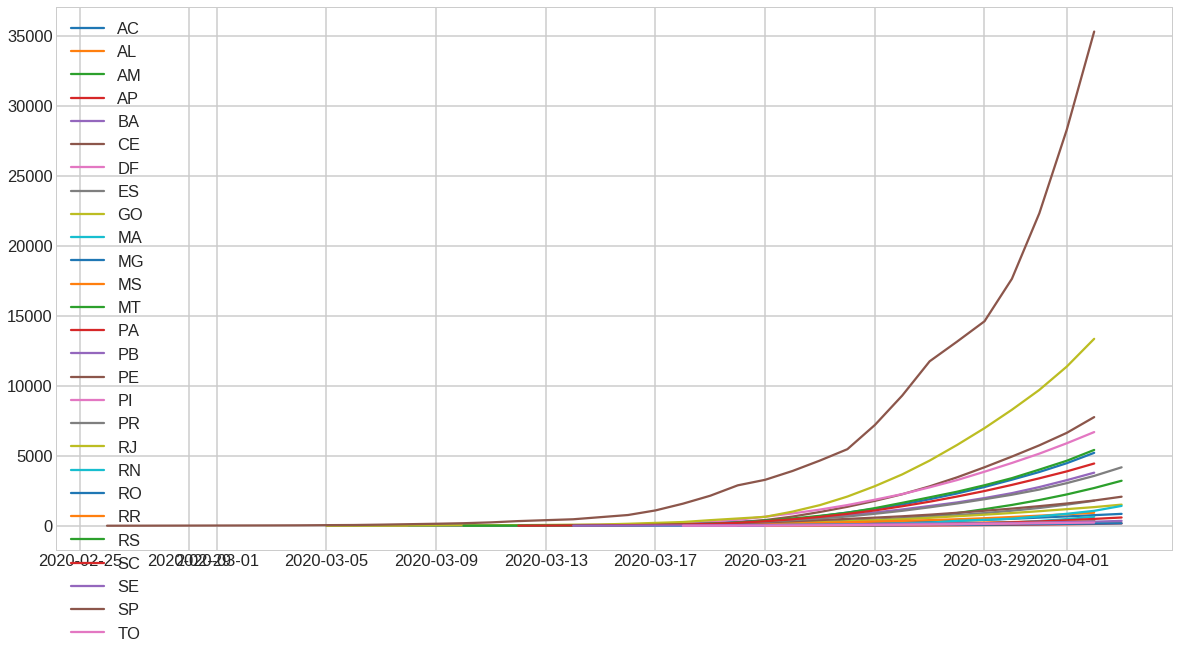

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
for uf in group_uf["state"].drop_duplicates():
    mask = group_uf["state"] == uf
    ax.plot(group_uf.loc[mask, "date"], group_uf.loc[mask, ["CumSum_confirmed"]], label=uf)
    
plt.legend()

# COVID-19 Growth Rate Prediction
> Predictions of COVID-19 Growth Rates Using Bayesian Modeling

- comments: true
- author: Thomas Wiecki & Hamel Husain
- categories: [growth, MCMC]
- image: images/covid-bayesian.png
- permalink: /growth-bayes/

> Note: This dashboard contains the results of a predictive model. The author has tried to make it as accurate as possible. But the COVID-19 situation is changing quickly, and these models inevitably include some level of speculation.

In [10]:
#hide

# df = load_covid_data.load_data(drop_states=True, filter_n_days_100=2)
# We only have data for China after they already had a significant number of cases.
# They also are not well modeled by the exponential, so we drop them here for simplicity.
# df = df.loc[lambda x: x.country != 'China (total)']

states = group_uf["state"].dropna().drop_duplicates()
n_states = len(states)
df = group_uf.loc[lambda x: (x.days_since_100 >= 0)]

# annotate_kwargs = dict(
#     s='Based on COVID Data Repository by Johns Hopkins CSSE ({})\nBy Thomas Wiecki'.format(df.index.max().strftime('%B %d, %Y')), 
#     xy=(0.05, 0.01), xycoords='figure fraction', fontsize=10)

# COVID-19 Growth Rate Prediction
> Predictions of COVID-19 Growth Rates Using Bayesian Modeling

- comments: true
- author: Thomas Wiecki & Hamel Husain
- categories: [growth, MCMC]
- image: images/covid-bayesian.png
- permalink: /growth-bayes/

> Note: This dashboard contains the results of a predictive model. The author has tried to make it as accurate as possible. But the COVID-19 situation is changing quickly, and these models inevitably include some level of speculation.

These are the countries included in the model:

In [11]:
#hide_input
',   '.join(sorted(df.state.unique().tolist()))

'AC,   AL,   AM,   AP,   BA,   CE,   DF,   ES,   GO,   MA,   MG,   MS,   MT,   PA,   PB,   PE,   PI,   PR,   RJ,   RN,   RO,   RR,   RS,   SC,   SE,   SP,   TO'

In [12]:
#hide

#####################################
##### This Cell Runs The Model ######
#####################################

with pm.Model() as model:
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 100, 50)
    # Group variance
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind = pm.Normal('a_ind', 
                      mu=a_grp, sigma=a_grp_sigma, 
                      shape=n_states)
    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', 1.33, .5)
    # Group variance
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .5)
    # Individual slopes
    b_ind = pm.Normal('b_ind', 
                      mu=b_grp, sigma=b_grp_sigma, 
                      shape=n_states)
    
    # Error
    sigma = pm.HalfNormal('sigma', 500., shape=n_states)
    
    # Create likelihood for each country
    for i, state in enumerate(states):
        df_state = df.loc[lambda x: (x.state == state)]
        
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(state + "x_data", 
                    df_state.days_since_100.values)
        confirmed = pm.Data(state + "y_data", 
                            df_state.confirmed.astype('float64').values)
        
        # Likelihood
        pm.NegativeBinomial(
            state, 
            (a_ind[i] * b_ind[i] ** x), # Exponential regression
            sigma[i], 
            observed=confirmed)

In [14]:
#hide
with model:
    # Sample posterior
    trace = pm.sample(tune=1500, chains=1, cores=2, target_accept=.9)
    
    # Update data so that we get predictions into the future
    for state in states:
        df_state = df.loc[lambda x: (x.state == state)]
        x_data = np.arange(0, 30)
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({state + "x_data": x_data})
        pm.set_data({state + "y_data": y_data})
    
    # Sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=80)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, b_ind, b_grp_sigma, b_grp, a_ind, a_grp_sigma, a_grp]
Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [02:46<00:00, 11.99it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 80/80 [00:30<00:00,  2.65it/s]


## Predicted Cases By Country

Select a country from the drop down list below to toggle  the visualization. 

In [17]:
#hide

##############################################
#### Pre processing of Data For Altair Viz ###
##############################################

# Flatten predictions & target for each country into a pandas DataFrame
prediction_dfs_list = []

for state in post_pred:
    arr = post_pred[state]
    preds = arr.flatten().tolist() # get predictions in a flattened array
    pred_idx = np.indices(arr.shape)[0].flatten().tolist() # prediction for model (there are many per country, thes are the grey lines)
    days_since = np.indices(arr.shape)[1].flatten().tolist() # days since 100 cases
    pred_df = pd.DataFrame({'state': state, 
                            'predictions': preds, 
                            'pred_idx': pred_idx,
                            'days_since_100': days_since}
                          )
    prediction_dfs_list.append(pred_df)

predictionsDF = pd.concat(prediction_dfs_list)


# Compute the maximum value to plot on the y-axis as 15x the last confirmed case
ylims = pd.DataFrame(df.groupby('state').last().confirmed * 15).reset_index()
ylims.columns = ['state', 'ylim']


# Filter out any predictions exceed the y-axis limit
predictionsDF_filtered = (predictionsDF.merge(ylims, on='state', how='left')
                         .loc[lambda x: x.predictions <= x.ylim])


# Compute a 33% daily growth rate (dashed line) as a reference for visualizations
first_case_count = df.groupby('state').first().confirmed.reset_index()
date_anchor = predictionsDF_filtered[['state', 'days_since_100']].drop_duplicates()
max_pred = predictionsDF_filtered.groupby('state').max()[['predictions']].reset_index()
benchmark = (date_anchor
             .merge(first_case_count, on='state', how='left')
             .merge(max_pred, on='state', how='left')
            )
benchmark['benchmark'] = benchmark.apply(lambda x: x.confirmed * (1.3**(x.days_since_100)),
                                         axis=1)
benchmarkDF_filtered = benchmark.loc[lambda x: x.benchmark <= x.predictions]


# Compute the last known total confirmed case, which is the black dot at the end of the red line in the viz
lastpointDF = df.groupby('state').last().reset_index()


# DataFrame of Chart Titles by country.  This a enables a hack to allow Altiar to switch values
titleDF = lastpointDF[['state']]
titleDF['title'] = titleDF.apply(lambda x: x.state + ': Actual vs. Predicted Growth',
                             axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
#hide_input

##################################
#### Construct The Altair Viz ####
##################################

alt.data_transformers.disable_max_rows()

selectState = alt.selection_single(
    name='Select',
    fields=['state'],
    init={'state': 'SP'},
    bind=alt.binding_select(options=sorted(states.tolist()))
)

##### Model Predictions (Grey) #####
width = 275
height= 250

pred = (alt.Chart(predictionsDF_filtered)
        .mark_line(opacity=.15)
        .encode(x=alt.X('days_since_100:Q', axis=alt.Axis(title='Days since 100th confirmed case')),
                y=alt.Y('predictions:Q', 
                        axis=alt.Axis(title='Confirmed cases')),
                color=alt.Color('pred_idx:Q', legend=None, scale=None),)
        .transform_filter(selectState)
       ).properties(
    width=width,
    height=height
)  

predlog = (alt.Chart(predictionsDF_filtered)
        .mark_line(opacity=.15)
        .encode(x=alt.X('days_since_100:Q', axis=alt.Axis(title='Days since 100th confirmed case')),
                y=alt.Y('predictions:Q', 
                        axis=alt.Axis(title=None),
                        scale=alt.Scale(type='log', base=10)),
                color=alt.Color('pred_idx:Q', legend=None, scale=None),)
        .transform_filter(selectState)
        ).properties(
    width=width,
    height=height
)   

##### Mark The Last Case Count #####

# Point

last_point = (alt.Chart(lastpointDF)
              .mark_circle(color="black", size=40)
              .encode(x='days_since_100:Q',
                      y='confirmed:Q')
              .transform_filter(selectState)
             )

# Label
last_point_label = (alt.Chart(lastpointDF)
                    .mark_text(align='right', dx=-10, dy=-15, fontSize=15)
                    .encode(x='days_since_100:Q',
                            y='confirmed:Q',
                            text='confirmed')
                    .transform_filter(selectState)
                   )

##### Place 133% Dotted Line Reference On Graph #####
guide = (alt.Chart(benchmarkDF_filtered)
        .mark_line(color='black', opacity=.5, strokeDash=[3,3])
        .encode(x='days_since_100:Q',
                y='benchmark:Q',
                )
        .transform_filter(selectState)
        )


##### Dynamic Chart Title


title_main = alt.Chart(titleDF).mark_text(dy=-15, dx=325, size=20).encode(
    text='title:N'
    ).transform_filter(selectState)


title_linear = (alt.Chart(alt.Data(values=[{'title': 'Y axis is on a linear scale'}]))
                .mark_text(dy=-150, size=15)
                .encode(text='title:N')
               )
title_log = (alt.Chart(alt.Data(values=[{'title': 'Y axis is on a log scale'}]))
                .mark_text(dy=-150, size=15)
                .encode(text='title:N')
               )

###### Legend (Hacked)
source = pd.DataFrame.from_records([{"img": "https://covid19dashboards.com/images/covid-bayes-growth-legend.png"}])
legend = (alt.Chart(source)
          .mark_image(dy=-150,
                      width=200,
                      height=150)
          .encode(url='img')
         )

##### Actual Cases (Red) #####
actual = (alt.Chart(df).mark_line(color="red")
          .encode(x='days_since_100:Q',
                  y='confirmed:Q')
          .transform_filter(selectState)
         )

annotations = last_point + last_point_label + guide + actual
linear_chart = pred.add_selection(selectState) + annotations + title_linear
log_chart = predlog + annotations + title_log + title_log

##### Layer All Charts Together And Configure Formatting #####
(
((title_main + legend) & ( linear_chart | log_chart ))
.configure_title(fontSize=20)
.configure_axis(labelFontSize=15,titleFontSize=18, grid=False)
)

alt.VConcatChart(...)

## Growth Rate Predictions

PR
RS
SC
ES
MG
RJ
SP


Text(0.5, 0.98, 'Posterior of daily growth')

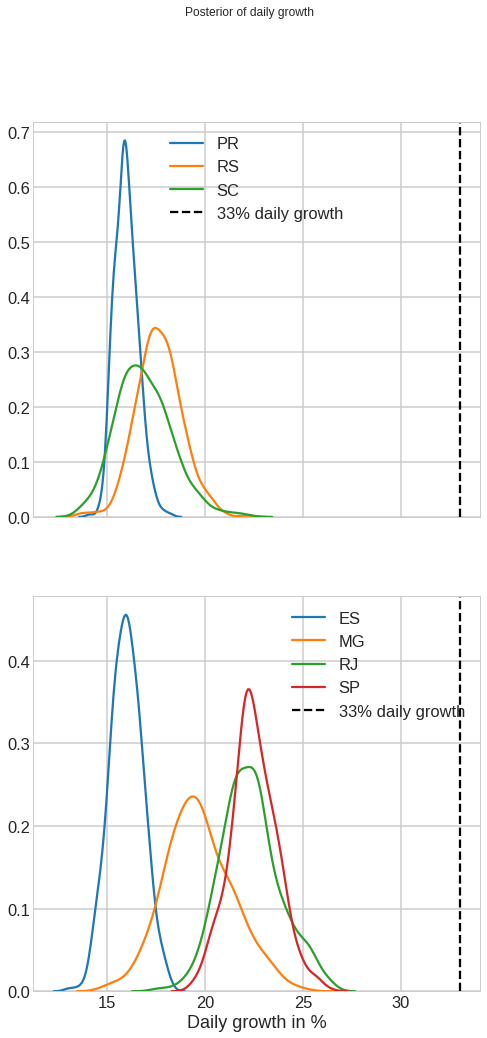

In [28]:
#hide_input

south = ["PR", "SC", "RS"]
southeast = ["SP", "RJ", "MG", "ES"]

state_groups = [south, southeast]
line_styles = ['-', ':', '--', '-.']


fig, axs = plt.subplots(nrows=len(state_groups), figsize=(8, 16), sharex=True)

for ax, state_group in zip(axs, state_groups):
    for i, state in enumerate(states):
        if state in state_group:
            print(state)
            sns.distplot((trace['b_ind'][:, i] * 100) - 100, ax=ax, label=state, hist=False)
        
    ax.axvline(33, ls='--', color='k', label='33% daily growth')
    ax.legend()
ax.set_xlabel('Daily growth in %')
plt.suptitle('Posterior of daily growth')

## Model Diagnostics - Trace Plots

The following trace plots help to assess the convergence of the MCMC sampler.  You can safely ignore this if not familiar with [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).

In [ ]:
#hide_input
az.plot_trace(trace, compact=True);

## About This Analysis

This analysis was done by [Thomas Wiecki](https://twitter.com/twiecki). Interactive visualizations were created by [Hamel Husain](https://twitter.com/HamelHusain).

The model that we are building assumes exponential growth. This is definitely wrong because growth would just continue uninterrupted into the future. However, in the early phase of an epidemic it's a reasonable assumption.[^1]

We assume a [negative binomial](https://docs.pymc.io/api/distributions/discrete.html#pymc3.distributions.discrete.NegativeBinomial) likelihood as we are dealing with count data. A Poisson could also be used but the negative binomial allows us to also model the variance separately to give more flexibility.

The model is also hierarchical, pooling information from individual countries.


[^1]:  This notebook gets up-to-date data from the ["2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/) [GitHub repository](https://github.com/CSSEGISandData/COVID-19). This code is provided under the [BSD-3 License](https://github.com/twiecki/covid19/blob/master/LICENSE). Link to [original notebook](https://github.com/twiecki/covid19/blob/master/covid19_growth_bayes.ipynb).